In [1]:
# https://github.com/gcdart/MulticlassClassifier/blob/master/src/ml/LogisticRegression.java
# https://www.kaggle.com/c/lshtc/discussion/6911#38233 - preprocessing: multilabels comma should not have spaces
# https://www.kaggle.com/c/lshtc/discussion/14048 - dataset statistics
## reading the LWIKI, SWIKI dataset

In [2]:
import os
import numpy as np
import pandas as pd
import igraph as ig

from pathlib import Path
from tqdm import tqdm #always use this instead of `import tqdm`
# from sklearn.datasets import fetch_rcv1

# np.random.seed(123)

In [3]:
import logging
from collections import OrderedDict

logging.basicConfig(level=logging.INFO)

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing, metrics

In [5]:
from joblib import Memory
from sklearn.datasets import load_svmlight_file

In [6]:
mem = Memory("./mycache")
@mem.cache
def get_data(filename):
    
    fname = str(Path(filename))
    fe, ex = os.path.splitext(fname) 

    try:
        data = load_svmlight_file(fname, multilabel=True)
    except:
        # Required: if the input data isn't in the correct libsvm format
        outfile = str(Path("{}_small{}".format(fe, ex)))
#         outfile = str(Path("{}_remapped{}".format(fe, ex)))
        if not os.path.isfile(outfile):
            logging.info("Remapping data to LibSVM format...")
            f = preprocess_libsvm(fname, outfile)
        else:
            logging.info("Using already remapped data...")
            f = outfile
        data = load_svmlight_file(f, multilabel=True)
        
    return data[0], data[1]

In [7]:
def preprocess_libsvm(input_file, output_file):
    # converts file to the required libsvm format.
    # this is very brute force but can be made faster [IMPROVE]

    file = open(output_file, "w+")
    with open(input_file, "r") as f:
        head = [next(f) for x in range(500)] # retrieve only `n` docs
        for i, line in enumerate(tqdm(head)): # change to f/head depending on your needs
            instance = line.strip().split()
            labels = instance[0]
            doc_dict = OrderedDict()
            temp_dict = {}
            temp_string = ''

            for pair in instance[1:]:
                feat = pair.split(":")
                if int(feat[0]) not in temp_dict:
                    temp_dict[int(feat[0])] = int(feat[1])

            for key in sorted(temp_dict.keys()):
                doc_dict[key] = temp_dict[key]

            for feat, tf in doc_dict.items():
                temp_string = temp_string + "{}:{} ".format(feat, tf)        
            file.write("{} {}\n".format(labels, temp_string))
        file.close()

    return output_file

In [8]:
def label_extractor(labels):

    leaf_labels = set()
    labels_per_doc = []

    for i in labels:
        labels_per_doc.append(len(i))
        for j in i:
            leaf_labels.add(int(j))
    
    return leaf_labels, labels_per_doc

In [9]:
def read_hier(filename):
    
    N = set()
    pi = set()
    T = set()
    
    with open(filename, "r") as f:
        for i, line in enumerate(f):
            words = line.strip().split()
            pi.add(int(words[0])) #adding parent node
            T.add(int(words[-1])) #adding ALL leaf nodes in the hierarchy
            for w in words:
                N.add(int(w))

    return N, pi, T

In [10]:
mem = Memory("./mycache")
@mem.cache
def rr_reader(filename):
    '''
    create a dataframe from the data-label pair
    '''

    num_entries = 100000
    df = pd.DataFrame()
    
    with open(filename, "r") as f:
        head = [next(f) for x in range(100000)] # retrieve only `n` docs
        for i, line in enumerate(tqdm(head)): # change to f/head depending on your needs
            instance = line.strip().split()
            labels = instance[0]
            doc_dict = OrderedDict()
            temp_dict = {}

            for pair in instance[1:]:
                feat = pair.split(":")
                if int(feat[0]) not in temp_dict:
                    temp_dict[int(feat[0])] = int(feat[1])

            for key in sorted(temp_dict.keys()):
                doc_dict[key] = temp_dict[key]
                
            temp_df = pd.DataFrame(data = [ labels, doc_dict ]).T
            df = df.append(temp_df, ignore_index=True)
    
    df.columns = ["labels", "feat_tf"]
    df["labels"] = df["labels"].apply( lambda x: list(map(int, x.split(",")))  )
    return df

In [11]:
df = rr_reader("swiki/data/train.txt")

In [12]:
df.head(5)

,labels,feat_tf
0,"[33692, 13402, 393382]","{624: 3, 4288: 1, 14403: 1, 54278: 1, 62619: 1..."
1,[130762],"{120505: 1, 173442: 1, 554009: 1, 634374: 1, 6..."
2,"[352578, 395447, 27512, 157031]","{62483: 1, 73429: 1, 138155: 1, 160218: 1, 165..."
3,"[390846, 395447, 276114]","{200187: 1, 207596: 1, 343448: 1, 359544: 1, 4..."
4,"[14661, 71999, 292915, 188756, 131368]","{2906: 1, 4288: 1, 17471: 3, 56146: 1, 94588: ..."


In [13]:
Nn, pii, Ti = read_hier("swiki/data/cat_hier.txt")

In [14]:
print(len(Nn), len(Ti)) # there is one node without any parent
print(Nn.difference(Ti)) # this is the node: this is probably the root node i guess

50312 50311
{2143406}


In [15]:
len(pii)

13808

In [28]:
 def lookup_table(filename, subset):
        
    p2c_table = {}
    c2p_table = {}
    node2id = OrderedDict()
    id2node = OrderedDict()
    i = 0
    
    with open(filename, "r") as f:
        if not subset:
            head = f
        elif isinstance(subset, int):
            head = [next(f) for x in range(subset)] # retrieve only `n` docs
        else:
            raise ValueError("Incorrect subset type. Enter only False (boolean) or int. Encountered {} type.".format(type(subset)))
        for _, line in enumerate(tqdm(head)):
            split_line = line.strip().split()
            parent_node = int(split_line[0])
            child_node = list(map(int, split_line[1:]))
            
            # map to the respective dicts -> parent:child relationship
            # parent2child lookup table
            if parent_node not in p2c_table:
                p2c_table[parent_node] = [child_node[0]]
            else:
                p2c_table[parent_node].append(child_node[0])
                
            #child2parent lookup table
            if child_node[0] not in c2p_table:
                c2p_table[child_node[0]] = [parent_node]
            else:
                c2p_table[child_node[0]].append(parent_node)
                
            # map parent/child node to a node<->id
            if parent_node not in node2id:
                p_id = i
                node2id[parent_node] = p_id
                id2node[p_id] = parent_node
                i+=1
            else:
                p_id = node2id[parent_node]
                
            if child_node[0] not in node2id:
                c_id = i
                node2id[child_node[0]] = c_id
                id2node[c_id] = child_node[0]      
                i+=1
            else:
                c_id = node2id[child_node[0]]

    pi_parents = set(p2c_table.keys())        
    T_leaves = (c2p_table.keys() - p2c_table.keys()) 
    N_all_nodes = pi_parents.union(T_leaves)
    
    return p2c_table, c2p_table, node2id, id2node, list(pi_parents), list(T_leaves), list(N_all_nodes)

In [17]:
def hierarchy2graph(p2c_table, node2id):

    edges = []
    for parent, children in p2c_table.items():
        p_id = node2id[parent]
        for child in children:
            c_id = node2id[child]
            edges.append((p_id, c_id))
    vertices = [k for k, v in node2id.items()]
    g = ig.Graph(n=len(node2id), edges=edges, directed=True, vertex_attrs={"name": vertices})
    return g

In [30]:
p2c, c2p, n2i, i2n, pi, T, N = lookup_table("swiki/data/cat_hier.txt", subset = False)
p2c_s, c2p_s, n2i_s, i2n_s, pi_s, T_s, N_s = lookup_table("swiki/data/cat_hier.txt", subset = 50)

65333it [00:00, 163088.47it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 49872.82it/s]


In [19]:
len(pi), len(T), len(N)

(13808, 36504, 50312)

In [20]:
g = hierarchy2graph(p2c_s, n2i_s)

In [21]:
print(g)

IGRAPH DN-- 51 50 --
+ attr: name (v)
+ edges (vertex names):
2143406->2156813, 2143406->2322682, 2143406->143406, 2143406->2255744,
2143406->2235965, 2156813->2440809, 2156813->2159645, 2156813->2267844,
2156813->2271677, 2156813->2152343, 2156813->1008038, 2156813->2310019,
2156813->2266243, 2156813->2426918, 2156813->2334805, 2156813->2132486,
2156813->2078122, 2156813->2057861, 2156813->2271281, 2156813->1012550,
2156813->2042688, 2156813->2373246, 2156813->2244017, 2156813->156813,
2322682->2013402, 2322682->2037186, 2322682->2341442, 2322682->2031546,
2322682->2305909, 2322682->2205397, 2322682->1112766, 2322682->2230320,
2322682->2402750, 2322682->2326915, 2322682->2242317, 2322682->2418165,
2322682->2196567, 2322682->2256232, 2322682->2127748, 2322682->2305967,
2322682->2436982, 2322682->2207289, 2322682->2386980, 2322682->2151145,
2322682->2080615, 2322682->322682, 2255744->2312526, 2255744->2324773,
2255744->2127372, 2255744->2091567


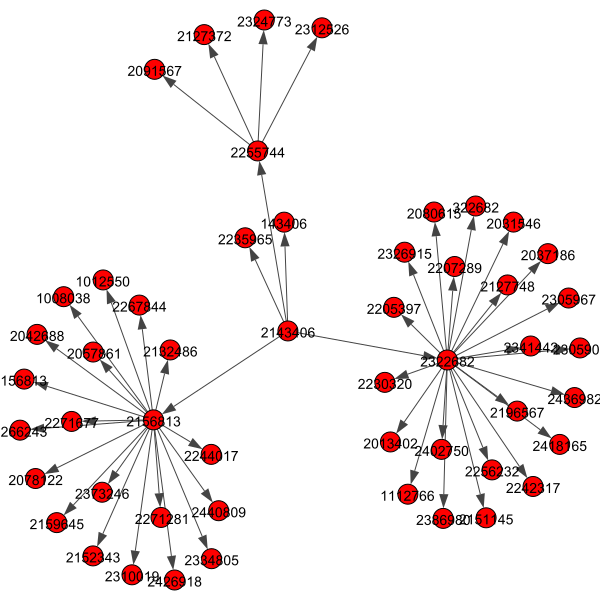

In [22]:
layout = g.layout("kk")
g.vs["label"] = g.vs["name"]
ig.plot(g, layout = layout)